## Generating rarefaction curves for the sequencing data
### From https://github.com/joey711/phyloseq/issues/143

In [1]:
# Loading R packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(plyr)
library(dplyr)
#library(plotly)
library(wesanderson)
library(breakaway)


Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Importing the dataset
ps = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results/ps.merged")


In [3]:
calculate_rarefaction_curves <- function(psdata, measures, depths) {
  require('plyr') # ldply
  require('reshape2') # melt

  estimate_rarified_richness <- function(psdata, measures, depth) {
    if(max(sample_sums(psdata)) < depth) return()
    psdata <- prune_samples(sample_sums(psdata) >= depth, psdata)

    rarified_psdata <- rarefy_even_depth(psdata, depth, verbose = FALSE)

    alpha_diversity <- estimate_richness(rarified_psdata, measures = measures)

    # as.matrix forces the use of melt.array, which includes the Sample names (rownames)
    molten_alpha_diversity <- melt(as.matrix(alpha_diversity), varnames = c('Sample', 'Measure'), value.name = 'Alpha_diversity')

    molten_alpha_diversity
  }

  names(depths) <- depths # this enables automatic addition of the Depth to the output by ldply
  rarefaction_curve_data <- ldply(depths, estimate_rarified_richness, psdata = psdata, measures = measures, .id = 'Depth', .progress = ifelse(interactive(), 'text', 'none'))

  # convert Depth from factor to numeric
  rarefaction_curve_data$Depth <- as.numeric(levels(rarefaction_curve_data$Depth))[rarefaction_curve_data$Depth]

  rarefaction_curve_data
}

In [4]:
rarefaction_curve_data = calculate_rarefaction_curves(ps, c('Observed'), rep(c(1, 100, 500, 1000, 2000, 5000, 10000, 20000), each = 10))
summary(rarefaction_curve_data)

Loading required package: reshape2

Attaching package: ‘reshape2’

The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast



     Depth               Sample         Measure         value       
 Min.   :    1   X15S.NT.19O:  80   Observed:7930   Min.   :   1.0  
 1st Qu.:  100   X15S.NT.20O:  80                   1st Qu.:  81.0  
 Median : 1000   X15S.NT.21M:  80                   Median : 262.5  
 Mean   : 4410   X15S.NT.21O:  80                   Mean   : 286.2  
 3rd Qu.: 5000   X15S.NT.22O:  80                   3rd Qu.: 418.0  
 Max.   :20000   X15S.NT.23M:  80                   Max.   :1674.0  
                 (Other)    :7450                                   

In [5]:
rarefaction_curve_data_summary = ddply(rarefaction_curve_data, c('Depth', 'Sample', 'Measure'), summarise, alpha_diversity_mean = mean(value), alpha_diversity_sd = sd(value))

In [6]:
sample_names(ps) = paste("X",sample_names(ps) ,sep="")
sample_names(ps) = gsub("-",".", sample_names(ps))

In [7]:
rarefaction_curve_data_summary_verbose = merge(rarefaction_curve_data_summary, data.frame(sample_data(ps)), by.x = 'Sample', by.y = 'row.names')

In [8]:
rarefaction_curve_data_summary_verbose$Overstory_CBI = as.numeric(rarefaction_curve_data_summary_verbose$Overstory_CBI)
rarefaction_curve_data_summary_verbose$CFSI = as.numeric(rarefaction_curve_data_summary_verbose$CFSI)

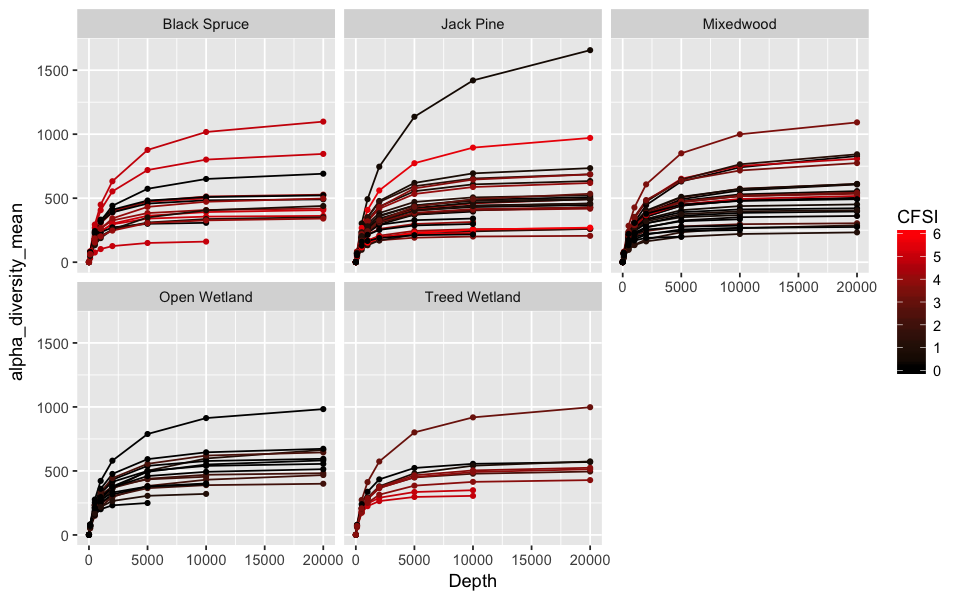

In [9]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(
  data = rarefaction_curve_data_summary_verbose,
  mapping = aes(
    x = Depth,
    y = alpha_diversity_mean,
    ymin = alpha_diversity_mean - alpha_diversity_sd,
    ymax = alpha_diversity_mean + alpha_diversity_sd,
    colour = CFSI,
    group = Sample
  )
) + geom_line(
#) + scale_colour_manual(values=c("black","darkred")
) + scale_colour_gradient(low="black",high="red"
) + geom_pointrange(size=0.1
) + facet_wrap(facets = ~ Veg_Comm) + scale_x_continuous(limits = c(0, 20000))

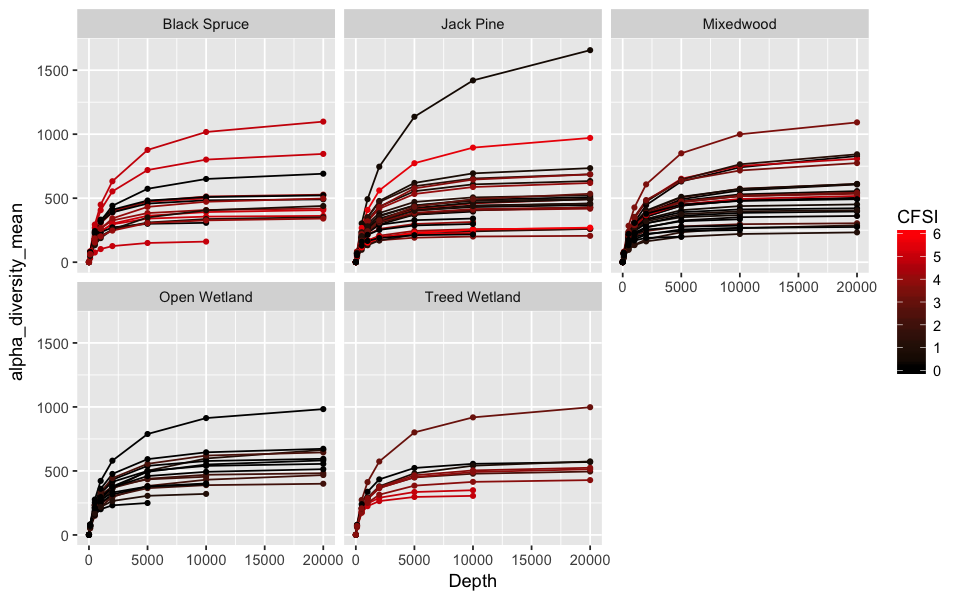

In [10]:
#Previously
options(repr.plot.width=8, repr.plot.height=5)
ggplot(
  data = rarefaction_curve_data_summary_verbose,
  mapping = aes(
    x = Depth,
    y = alpha_diversity_mean,
    ymin = alpha_diversity_mean - alpha_diversity_sd,
    ymax = alpha_diversity_mean + alpha_diversity_sd,
    colour = CFSI,
    group = Sample
  )
) + geom_line(
#) + scale_colour_manual(values=c("black","darkred")
) + scale_colour_gradient(low="black",high="red"
) + geom_pointrange(size=0.1
) + facet_wrap(facets = ~ Veg_Comm) + scale_x_continuous(limits = c(0, 20000))

## Calculating richness estimates with Betta

In [11]:
FreqTableGenerator = function(Sample){
    df = data.frame(t(otu_table(ps))[,Sample])
    # Grab the OTU table
    colnames(df)="Frequency"
    # Add a column for the frequencies of the OTUs
    df = df %>%
        group_by(Frequency)%>%
        summarize(nOTUs=n())%>%
        arrange(Frequency)
    # Summarize the total OTUs that are present at each frequency
    df = df[df$Frequency>1,]
    # Cut out the 0 and 1 frequencies (because dada2 trimmed singletons)
    colnames(df)=NULL
    # Omit column names
    df = as.matrix(df)
    # Spit out a nice matrix
    df
}
# Generates the frequency table summary needed by breakaway

In [12]:
Samples = sample_names(ps)

In [13]:
report = data.frame(name="",Richness_estimate="",Richness_stderr="",Richness_model="")
breakawayrunner = function(SampleName){
    df = FreqTableGenerator(SampleName)
    #print(head(df))
    #print(SampleName)
    #print(sum(df[,1]*df[,2]))
    if(df[1,1]==2 & (sum(df[1:6,1])==sum(c(2:7)))){
        # First, check that the first frequency count is, indeed, 2,
        # and there are at least 6 consecutive counts (could actually just do this test)
            m = breakaway_nof1(df, answers=TRUE, plot=FALSE, print=FALSE)
        # Run breakaway for the no singletons data
            Richness_model = m$name
            Richness_estimate = m$est
            Richness_stderr = m$seest
            name = SampleName
        # Grab the outputs
            report = data.frame(name,Richness_estimate,Richness_stderr,Richness_model)
        # Generate a report
    } else {
        name = SampleName
        report=data.frame(name)
        # If breakaway isn't going to work anyway, just spit out the name (and NAs)
        }

    report

}

In [14]:
Reports = mdply(Samples,breakawayrunner)
head(Reports)

X1,name,Richness_estimate,Richness_stderr,Richness_model
1,X15S.NT.19O,1054.9262,3.148986,WLRM
2,X15S.NT.20O,726.7604,3.797964,WLRM
3,X15S.NT.21M,603.6152,163.789704,model_1_1
4,X15S.NT.21O,602.5721,910.531768,model_1_1
5,X15S.NT.22M,426.0093,5.338701,model_2_1
6,X15S.NT.22O,459.3855,3.822038,WLRM


In [15]:
Report_Summary = Reports %>%
    group_by(Richness_model)%>%
    summarize(n())
Report_Summary
# How many of each sample fit each model type

Richness_model,n()
WLRM,66
model_1_1,25
model_2_1,7
model_2_2,2
model_3_2,1
model_1_0,1


In [16]:
# Previous results
Report_Summary = Reports %>%
    group_by(Richness_model)%>%
    summarize(n())
Report_Summary
# How many of each sample fit each model type

Richness_model,n()
WLRM,66
model_1_1,25
model_2_1,7
model_2_2,2
model_3_2,1
model_1_0,1


In [17]:
sample_data(ps)[,colnames(Reports)[3:5]]=Reports[,3:5]

In [18]:
mdf = sample_data(ps)

In [19]:
mdf$CBI = as.numeric(mdf$CBI)
mdf$Burn_Severity_Index = as.numeric(mdf$Burn_Severity_Index)

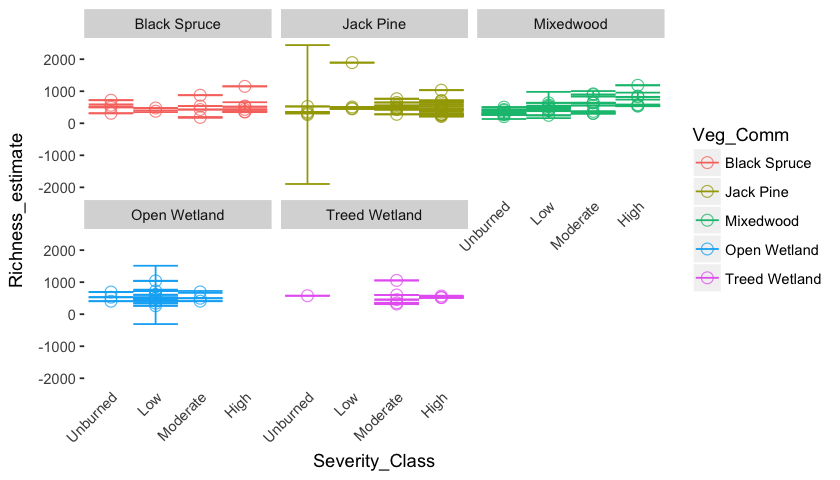

In [20]:
options(repr.plot.width=7, repr.plot.height=4)

p = ggplot(mdf, aes(Severity_Class, Richness_estimate, colour=Veg_Comm))
#p = p + geom_boxplot()
p = p + geom_point(size=3,pch=21, alpha=0.75)
p = p + geom_errorbar(aes(ymin = Richness_estimate-Richness_stderr, ymax = Richness_estimate+Richness_stderr), width = 1)
#p = p + ylim(0,1000)
p = p + facet_wrap(~Veg_Comm)
p = p + theme(axis.text.x=element_text(angle=45, hjust=1)
              ,axis.ticks.x=element_blank()
             #,panel.grid=element_blank()
             ,panel.background=element_blank()
             )
p
# 15S-NT-41M is the really high Jack Pine sample; it has an especially low CFSI; ~lower nutrients

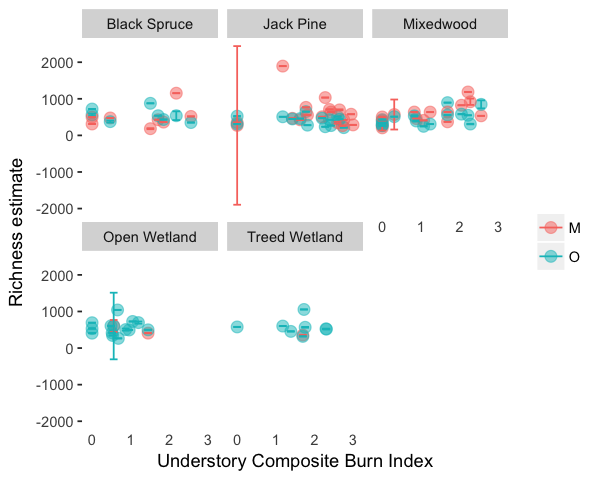

In [21]:
options(repr.plot.width=5, repr.plot.height=4)

p = ggplot(mdf, aes(Understory_CBI, Richness_estimate, colour=Org_or_Min))
#p = p + geom_boxplot()
p = p + geom_point(size=3, alpha=0.5)
p = p + geom_errorbar(aes(ymin = Richness_estimate-Richness_stderr, ymax = Richness_estimate+Richness_stderr), width = 0.2)
#p = p + ylim(0,2000)
#p = p + facet_wrap(~Veg_Comm)
p = p + theme(#axis.text.x=element_text(angle=45, hjust=1)
              ,axis.ticks.x=element_blank()
             #,panel.grid=element_blank()
             ,panel.background=element_blank()
             )
p = p + guides(colour=guide_legend(title=""))
p = p + ylab("Richness estimate")
p = p + xlab("Understory Composite Burn Index")
p = p + facet_wrap(~Veg_Comm)
p
# 15S-NT-41M is the really high Jack Pine sample; it has an especially low CFSI; ~lower nutrients

In [22]:
df = mdf %>%
    group_by(Veg_Comm, Severity_Class)%>%
    summarize(Richness_estimate = mean(Richness_estimate, na.rm=TRUE), StdErr = sum(Richness_stderr^2)/n(),N=n())
df
# Amy Willis confims this would be an appropriate error propagation approach, 
# but suggests using the betta() function to do the same thing

Veg_Comm,Severity_Class,Richness_estimate,StdErr,N
Black Spruce,Unburned,522.9016,2.437316e+02,4
Black Spruce,Low,426.3028,3.594599e+02,2
Black Spruce,Moderate,506.5861,5.572903e+01,4
Black Spruce,High,559.2850,2.385864e+03,6
Jack Pine,Unburned,364.7807,1.174946e+06,4
Jack Pine,Low,829.6506,6.258666e+00,4
Jack Pine,Moderate,514.2442,2.067367e+01,8
Jack Pine,High,472.4349,7.689863e+01,15
Mixedwood,Unburned,340.8360,6.652497e+02,8
Mixedwood,Low,470.6115,2.109601e+04,8


Warning message:
“Removed 5 rows containing missing values (geom_errorbar).”

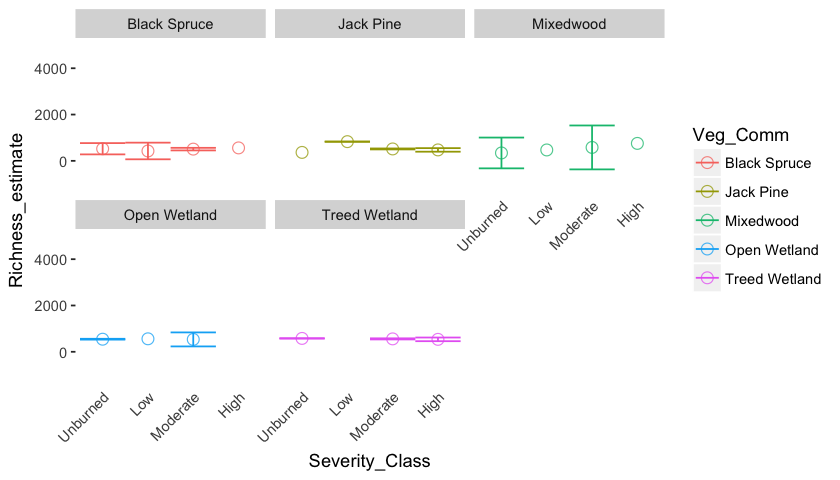

In [23]:
options(repr.plot.width=7, repr.plot.height=4)

p = ggplot(df, aes(x=Severity_Class, y=Richness_estimate, colour=Veg_Comm))
#p = p + geom_boxplot()
p = p + geom_point(size=3,pch=21, alpha=0.75)
p = p + geom_errorbar(aes(ymin = Richness_estimate-StdErr, ymax = Richness_estimate+StdErr), width = 1)
p = p + ylim(-1000,5000)
p = p + facet_wrap(~Veg_Comm)
p = p + theme(axis.text.x=element_text(angle=45, hjust=1)
              ,axis.ticks.x=element_blank()
             #,panel.grid=element_blank()
             ,panel.background=element_blank()
             )
p
# 15S-NT-41M is the really high Jack Pine sample; it has an especially low CFSI; ~lower nutrients

In [24]:
BettaRunner = function(Veg_Comm){
    df=mdf
    d = df[df$Veg_Comm==Veg_Comm,]
    CoVars = data.frame(Veg_Comm=d$Veg_Comm,Severity_Class=d$Severity_Class)
    CoVars$Severity=c(rep("",dim(CoVars)[1]))
    SeverityOptions = levels(CoVars$Severity_Class)
    N = length(SeverityOptions)
    for (i in 1:dim(CoVars)[1]){
        Severity_Class = paste(CoVars$Severity_Class[i])    
        if("Unburned" %in% SeverityOptions){CoVars$Unburned[i] = ifelse(Severity_Class=="Unburned",1,0)}
        if("Low" %in% SeverityOptions){CoVars$Low[i] = ifelse(Severity_Class=="Low",1,0)}
        if("Moderate" %in% SeverityOptions){CoVars$Moderate[i] = ifelse(Severity_Class=="Moderate",1,0)}
        if("High" %in% SeverityOptions){CoVars$High[i] = ifelse(Severity_Class=="High",1,0)}
    }
    nmax = 3+N
    CoVars = as.matrix(CoVars[,4:nmax])
    Richness_estimates = as.vector(d$Richness_estimate)
    Richness_stderr = as.vector(d$Richness_stderr)
    BettaEst = betta(Richness_estimates,Richness_stderr,CoVars)
    X = data.frame(BettaEst$table)
    X$Veg_Comm = Veg_Comm
    return(X)
}

In [25]:
Veg_Comms = levels(mdf$Veg_Comm)

In [26]:
x = lapply(Veg_Comms,FUN=BettaRunner)

In [27]:
x[[1]]$Severity_Class=row.names(x[[1]])
x[[2]]$Severity_Class=row.names(x[[2]])
x[[3]]$Severity_Class=row.names(x[[3]])
x[[4]]$Severity_Class=row.names(x[[4]])
x[[5]]$Severity_Class=row.names(x[[5]])

In [28]:
x = rbind(x[[1]],x[[2]],x[[3]],x[[4]],x[[5]])
x = data.frame(x)
x$p.adj = p.adjust(x$p.values, method = "bonferroni")
x$Ymin = x$Estimates-1.96*x$Standard.Errors
x$Ymax = x$Estimates+1.96*x$Standard.Errors
x$comb = paste(x$Veg_Comm,x$Severity_Class)
x

,Estimates,Standard.Errors,p.values,Veg_Comm,Severity_Class,p.adj,Ymin,Ymax,comb
Unburned,522.9016,117.13050,0.000,Black Spruce,Unburned,0.000,293.32582,752.4774,Black Spruce Unburned
Low,426.3028,165.82320,0.010,Black Spruce,Low,0.180,101.28934,751.3163,Black Spruce Low
Moderate,506.5862,116.93276,0.000,Black Spruce,Moderate,0.000,277.39795,735.7744,Black Spruce Moderate
High,559.2850,97.12559,0.000,Black Spruce,High,0.000,368.91888,749.6512,Black Spruce High
Unburned1,394.6994,180.09644,0.028,Jack Pine,Unburned,0.504,41.71041,747.6885,Jack Pine Unburned
Low1,829.6593,156.49111,0.000,Jack Pine,Low,0.000,522.93675,1136.3819,Jack Pine Low
Moderate1,514.2423,110.66406,0.000,Jack Pine,Moderate,0.000,297.34073,731.1439,Jack Pine Moderate
High1,472.4684,80.84068,0.000,Jack Pine,High,0.000,314.02068,630.9161,Jack Pine High
Unburned2,343.1036,66.00016,0.000,Mixedwood,Unburned,0.000,213.74333,472.4640,Mixedwood Unburned
Low2,459.0435,69.20647,0.000,Mixedwood,Low,0.000,323.39878,594.6882,Mixedwood Low


In [29]:
x$Severity_Class=factor(x$Severity_Class,levels=c("Unburned","Low","Moderate","High"))

In [30]:
x$Veg_Comm = factor(x$Veg_Comm, levels=c("Black Spruce", "Jack Pine", "Mixedwood", "Treed Wetland", "Open Wetland"))

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

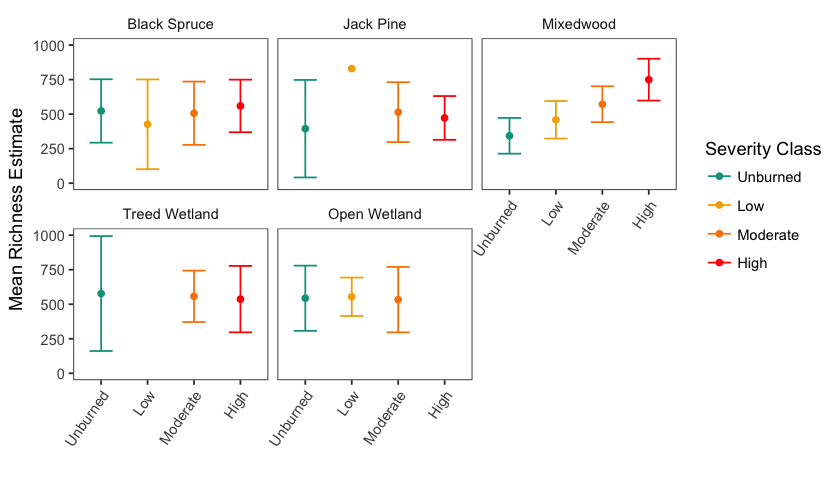

In [31]:
options(repr.plot.width=7, repr.plot.height=4)
p = ggplot(x)
p = p + geom_errorbar(aes(x=Severity_Class,min = Ymax, max = Ymin,color=Severity_Class),width=0.5)
p = p + geom_point(aes(x=Severity_Class,y=Estimates,color=Severity_Class))
#p = p + geom_point(aes(x=Severity_Class,y=Estimates-1.96*Standard.Errors,color=Severity_Class))
#p = p + geom_point(aes(x=Severity_Class,y=Estimates+1.96*Standard.Errors,color=Severity_Class))
p = p + facet_wrap(~Veg_Comm)
#p = p + ylim(-500,1500)
p = p + ylim(0,1000)
palette = wes_palette("Darjeeling")[c(2,3,4,1,5)]
p = p + scale_colour_manual(values=palette)
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    #,strip.text.x = element_text(size=14, face="bold")
        #,axis.title = element_text(size=22, face="bold")
        #,axis.text = element_text(size=16)
        #,legend.text = element_text(size=16)
        #,legend.title = element_text(size = 22)
        ,strip.background = element_rect(colour="white", fill="white"))
p = p + theme(axis.text.x = element_text(angle=55,hjust=1))
p = p + ylab("Mean Richness Estimate")
p = p + xlab("")
p = p + guides(colour=guide_legend(title="Severity Class"))
p

Warning message:
“Removed 7 rows containing missing values (geom_point).”

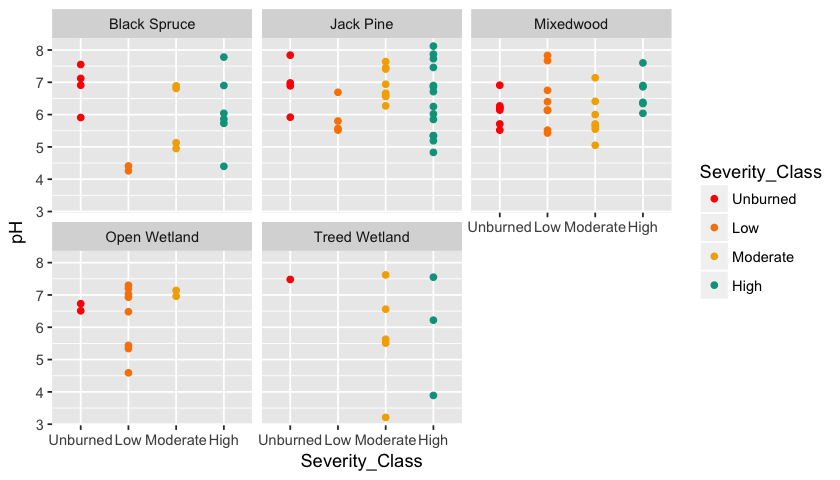

In [64]:
p = ggplot(data.frame(sample_data(ps)))
p = p + geom_point(aes(y=pH,x=Severity_Class, colour=Severity_Class))
p = p + facet_wrap(~Veg_Comm)
palette = wes_palette("Darjeeling")[c(1,4,3,2,5)]
p = p + scale_colour_manual(values=palette)
p

### What if we merged samples by veg comm and severity class first, before calculating the error?
### This would be asking, what is the total richness within a given category? There's an issue, though, of the total number of samples. So, it might be off?

In [49]:
sample_data(ps)$VegSev = paste(sample_data(ps)$Veg_Comm,sample_data(ps)$Severity_Class,sep="-")

In [50]:
ps.merged = merge_samples(ps, "VegSev")

Warning message in asMethod(object):
“NAs introduced by coercion”

In [53]:
ps = ps.merged
Samples = sample_names(ps)
Reports = mdply(Samples,breakawayrunner)
head(Reports)

X1,name,Richness_estimate,Richness_stderr,Richness_model
1,Black Spruce-High,2418.7800,5.271244,WLRM
2,Black Spruce-Low,642.4455,3.528731,WLRM
3,Black Spruce-Moderate,1648.6343,4.427594,WLRM
4,Black Spruce-Unburned,1599.2127,22.087282,model_1_1
5,Jack Pine-High,3740.1967,6.470861,WLRM
6,Jack Pine-Low,2714.8298,3.779461,WLRM


In [61]:
Reports$name = factor(Reports$name, levels=c('Black Spruce-Unburned', 'Black Spruce-Low', 'Black Spruce-Moderate', 'Black Spruce-High', 'Jack Pine-Unburned','Jack Pine-Low', 'Jack Pine-Moderate', 'Jack Pine-High',  'Mixedwood-Unburned' ,'Mixedwood-Low', 'Mixedwood-Moderate', 'Mixedwood-High', 'Open Wetland-Unburned' ,'Open Wetland-Low' ,'Open Wetland-Moderate','Treed Wetland-Unburned',  'Treed Wetland-Moderate', 'Treed Wetland-High'))

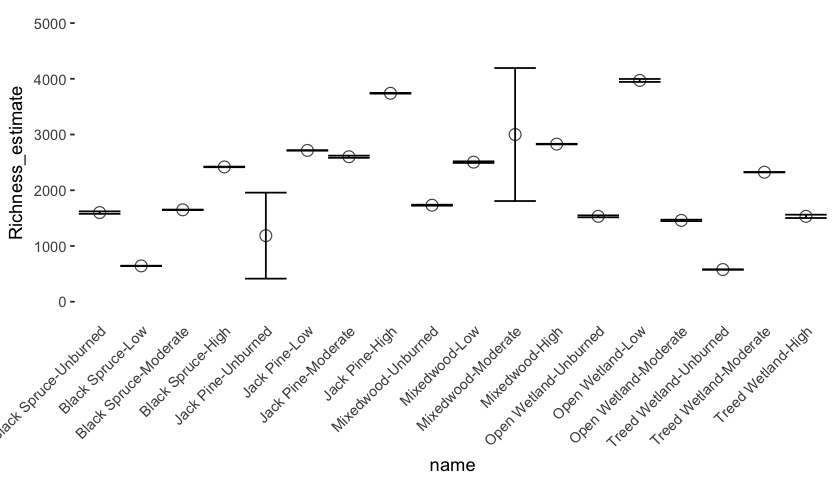

In [62]:
options(repr.plot.width=7, repr.plot.height=4)

mdf = Reports

p = ggplot(mdf, aes(name, Richness_estimate))
#p = p + geom_boxplot()
p = p + geom_point(size=3,pch=21, alpha=0.75)
p = p + geom_errorbar(aes(ymin = Richness_estimate-Richness_stderr, ymax = Richness_estimate+Richness_stderr), width = 1)
p = p + ylim(0,5000)
#p = p + facet_wrap(~Veg_Comm)
p = p + theme(axis.text.x=element_text(angle=45, hjust=1)
              ,axis.ticks.x=element_blank()
             #,panel.grid=element_blank()
             ,panel.background=element_blank()
             )
p
# No real clear trends.